# Testing the likelihood external file

To start playing with this notebook, install the ```Likelihood Package``` and its modules according to README.
Alternatively you may be ready to run if ```Cobaya``` and ```CAMB/CLASS``` are installed.

Cobaya documentation: https://cobaya.readthedocs.io/en/latest/

In [44]:
#General imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate 

plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=15)
#plt.rc('figure', autolayout=True)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=17)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=6)
plt.rc('legend', fontsize=20)
plt.rc('mathtext', fontset='stix')
plt.rc('font', family='STIXGeneral')

### Specific imports

In [45]:
#Import cobaya -need to be installed
import cobaya
#Import external loglike from the Likelihood Package within cobaya interface module
from likelihood.cobaya_interface import EuclidLikelihood

### Step 1: create your dictionary with general specifications

In ```COBAYA```, 'ini files' are 'yaml files', which are in reality understood by Cobaya as python dictionaries. I have added comments explaining each of the lines of the dictionary.


In [46]:
#ATTENTION: CHANGE THIS TO YOUR LOCAL PATH where your external codes are installed: CAMB, polychord, likelihoods...
modules_path = "/data2/cobaya_modules/"
h=0.67
# Info is the 'ini file' dictionary. 
# You can translate this info-dictionary into a yaml file and run: cobaya-run info.yaml such as CosmoMC like

info = {
    #Which parameters would you like to sample?
    'params': {
        # Fixed
        'ombh2': 0.05*h**2, 'omch2': 0.268563*h**2, 'H0': 67, 'tau': 0.0925,
        'mnu': 0.06, 'nnu': 2.046, 'omnuh2': 0.00143717*h**2,
        # Sampled - just as an example we assume we will be sampling over ns
        'ns': 0.96, #{'prior': {'min': 0.8, 'max': 1.2}},
        #To be passed to euclid which likelihood to use (preliminary)
        # 1: shear
        # 2: spec
        # 12: both
        'like_selection': 12,
        'As': 2.12605e-9},
    #Which theory code you want to use? HERE CAMB
    'theory': {'camb': {'stop_at_error': True, 'extra_args':{'num_massive_neutrinos': 1}}},
    #Which sample do you want to use? HERE I use MCMC for testing
    'sampler': {'mcmc': None},  
    #Where have you installed your modules (i.e: CAMB, polychord, likelihoods...)
    'packages_path': modules_path,
    #Where are the results going to be stored?
    'output': 'chains/my_euclid_experiment',
    #Likelihood: we load the likelihood as an external function
    'likelihood': {'Euclid': EuclidLikelihood},
    'debug': False,
    'force': True
    }

### Step 2: Call the 'model' wrapper of ```COBAYA```

In principle, we could run directly cobaya with the above dictionary and start producing chains. However, for testing purposes, the 'model' wrapper is created, which allows to enter directly to theory code's quantities. It works similarly as an 'evaluator'.

I use it here to give a feeling of what ```COBAYA``` is doing internally. Advice: good for debbuging too.

In [47]:
# Model wrapper of cobaya
from cobaya.model import get_model
model = get_model(info)

[model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'force']
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB


In [48]:
# Which theory requirements is the likelihood asking to the Boltzman Solver?
print('\n Requirements \n')
print(model.provider.requirement_providers)
# So, what have we requested?
print('\n Requested \n')
print(model.requested())


 Requirements 

{'Pk_interpolator': camb, 'comoving_radial_distance': camb, 'angular_diameter_distance': camb, 'Hubble': camb, 'sigma_R': camb, 'fsigma8': camb, 'CAMB_transfers': camb.transfers}

 Requested 

{'camb.transfers': [{'CAMB_transfers':{'non_linear': False, 'needs_perts': True}}], 'camb': [{'Pk_interpolator':{}}, {'comoving_radial_distance':{'z': array([0.        , 0.02525253, 0.05050505, 0.07575758, 0.1010101 ,
       0.12626263, 0.15151515, 0.17676768, 0.2020202 , 0.22727273,
       0.25252525, 0.27777778, 0.3030303 , 0.32828283, 0.35353535,
       0.37878788, 0.4040404 , 0.42929293, 0.45454545, 0.47979798,
       0.50505051, 0.53030303, 0.55555556, 0.58080808, 0.60606061,
       0.63131313, 0.65656566, 0.68181818, 0.70707071, 0.73232323,
       0.75757576, 0.78282828, 0.80808081, 0.83333333, 0.85858586,
       0.88383838, 0.90909091, 0.93434343, 0.95959596, 0.98484848,
       1.01010101, 1.03535354, 1.06060606, 1.08585859, 1.11111111,
       1.13636364, 1.16161616, 1.186

In [49]:
# To execute the likelihood, you need to make an evaluation of the posterior
# Attention: this chi2 for the moment, does not make sense yet
# if ns is sampled, we need to obtain a value from the prior
# point = dict(zip(model.parameterization.sampled_params(),
#                 model.prior.sample(ignore_external=True)[0]))
# As all parameters are fixed, just call the posterior

model.logposterior({})

LogPosterior(logpost=-15.0, logpriors=[0.0], loglikes=array([-15.]), derived=[])

In [50]:
# which parameters values does the model have?
print('\n Parameters \n')
print(model.provider.params)


 Parameters 

{'ombh2': 0.022445000000000007, 'omch2': 0.12055793070000002, 'H0': 67, 'tau': 0.0925, 'mnu': 0.06, 'nnu': 2.046, 'omnuh2': 0.0006451456130000001, 'ns': 0.96, 'like_selection': 12, 'As': 2.12605e-09}


### Step 3: Call the sampler of  ```COBAYA```

Let's check if ```cobaya```works properly with samplers

In [51]:
# for the moment it is commented out as we do not want to run the sampler
# from cobaya.run import run
# info_updated, samples = run(info)

### Step 4: Cosmology module and ```COBAYA```

In principle, the cobaya interface only pass cosmology parameters (for instance $\Omega_m$, $\Omega_b$, $H$) and ask for theory requirements from the boltzmann solver. Internally, the likelihood module uses the cosmology class to deal with the different GCspec, GCphot, WL recipes.

In [52]:
#Import Cosmology module from the Likelihood Package to play with cosmological quantities
from likelihood.cosmo.cosmology import Cosmology

In [53]:
# Some of the theory needs require extra info (redshift, ks)...
z_min = 0.0
z_max = 2.5
z_samp = 100
z_win = np.linspace(z_min, z_max, z_samp)
k_max = 0.2

In [54]:
# Cobaya_interface save the cosmology parameters and the cosmology requirements 
# from CAMB/CLASS via COBAYA to the cosmology class

# This dictionary collects info from cobaya
theory_dic = {'H0': model.provider.get_param('H0'),
                  'omch2': model.provider.get_param('omch2'),
                  'ombh2': model.provider.get_param('ombh2'),
                  'mnu': model.provider.get_param('mnu'),
                  'comov_dist': model.provider.get_comoving_radial_distance(z_win),
                  'angular_dist': model.provider.get_angular_diameter_distance(z_win),
                  'H': model.provider.get_Hubble(z_win),
                  'Pk_interpolator': model.provider.get_Pk_interpolator(nonlinear=False),
                  'Pk_delta': None,
                  'fsigma8': None,
                  'z_win': z_win
                  }
theory_dic['Pk_delta'] = model.provider.get_Pk_interpolator(("delta_tot", "delta_tot"), nonlinear=False)
theory_dic['fsigma8'] = model.provider.get_fsigma8(z_win)
R, z, sigma_R = model.provider.get_sigma_R()
print(R)
theory_dic['sigma_8'] = sigma_R[:, 0]

[11.94029851]


In [55]:
# Initialize cosmology class from likelihood.cosmo.cosmology
# By default: LCDM
cosmology = Cosmology()
print("Previous dic\n\n:", cosmology.cosmo_dic)

Previous dic

: {'H0': 67.5, 'omch2': 0.122, 'ombh2': 0.022, 'mnu': 0.06, 'tau': 0.07, 'nnu': 3.046, 'ns': 0.9674, 'As': 2.1e-09, 'comov_dist': None, 'angular_dist': None, 'H': None, 'Pk_interpolator': None, 'Pk_delta': None, 'fsigma8': None, 'b_gal': 1.0, 'sigma_8': None, 'c': 299792.458, 'z_win': None, 'r_z_func': None, 'd_z_func': None, 'H_z_func': None, 'sigma8_z_func': None, 'fsigma8_z_func': None}


In [56]:
# the cobaya_interface.py save cobaya theory dictionary as above into cosmology.cosmo_dic
cosmology.cosmo_dic.update(theory_dic)
cosmology.update_cosmo_dic(z_win, 0.005)
print("Updated dic\n\n:", cosmology.cosmo_dic)

Updated dic

: {'H0': 67, 'omch2': 0.12055793070000002, 'ombh2': 0.022445000000000007, 'mnu': 0.06, 'tau': 0.07, 'nnu': 3.046, 'ns': 0.9674, 'As': 2.1e-09, 'comov_dist': array([   0.        ,  112.30467359,  223.22159473,  332.73552331,
        440.83391322,  547.50684422,  652.74693913,  756.54926871,
        858.91124622,  959.83251359, 1059.31482128, 1157.36190358,
       1253.97935095, 1349.17448103, 1442.95620963, 1535.33492289,
       1626.32235164, 1715.93144893, 1804.17627131, 1891.0718646 ,
       1976.63415455, 2060.87984271, 2143.82630784, 2225.4915129 ,
       2305.89391782, 2385.05239786, 2462.98616775, 2539.71471127,
       2615.25771624, 2689.63501477, 2762.86652838, 2834.97221805,
       2905.97203867, 2975.88589787, 3044.73361888, 3112.53490711,
       3179.30932036, 3245.07624233, 3309.85485914, 3373.66413872,
       3436.52281287, 3498.44936169, 3559.46200022, 3619.57866714,
       3678.81701535, 3737.19440417, 3794.72789315, 3851.43423727,
       3907.32988333, 3962

In [57]:
# Cosmology class calculates other cosmology quantities needed by GC, WL...
# Growth factor
D=cosmology.growth_factor(z_win, 0.002)
print('D(z, 0.002) =', D)
# Growth rate
f=cosmology.growth_rate(z_win, 0.002)
print('f(0.0, 0.002) =', f(0.0))

D(z, 0.002) = [1.         0.98663844 0.97341674 0.96034412 0.94742862 0.93467745
 0.92209672 0.90969211 0.89746782 0.88542783 0.87357506 0.86191197
 0.85044024 0.83916102 0.82807501 0.81718238 0.80648296 0.79597591
 0.78566033 0.77553483 0.76559776 0.75584734 0.74628139 0.73689762
 0.72769355 0.71866663 0.70981403 0.701133   0.69262057 0.68427385
 0.67608968 0.66806509 0.66019685 0.65248199 0.64491723 0.63749966
 0.63022606 0.62309329 0.61609835 0.60923822 0.60250993 0.59591044
 0.58943695 0.58308647 0.57685631 0.57074358 0.56474567 0.55885978
 0.55308343 0.54741406 0.54184908 0.53638609 0.53102267 0.52575653
 0.52058539 0.51550698 0.51051915 0.50561972 0.50080678 0.49607814
 0.49143184 0.48686607 0.48237897 0.47796858 0.47363327 0.46937124
 0.46518083 0.46106036 0.45700834 0.45302313 0.4491032  0.44524712
 0.44145347 0.43772083 0.43404782 0.43043316 0.42687554 0.42337368
 0.41992644 0.41653254 0.4131909  0.40990034 0.40665978 0.40346812
 0.40032436 0.39722747 0.39417647 0.3911704  0.3

#### Cosmology plots

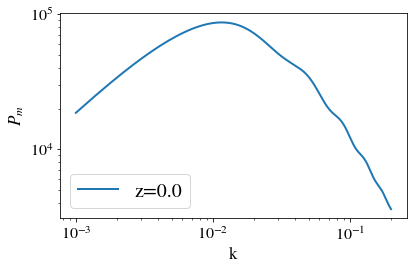

In [58]:
# Matter power spectrum
ks=np.linspace(1e-3, 0.2, 1000)
plt.loglog(ks, cosmology.cosmo_dic['Pk_delta'].P(z_win[0], ks), label=r"z={}".format(z_win[0]))
plt.xlabel("k");
plt.ylabel(r"$P_m$");
plt.legend();

In [59]:
# It seems that there is a bug in the calculation of D and f. Let's verufy with CLASS
from classy import Class
cosmo_class = Class()
cosmo_class.set({'omega_b':0.05*h**2,'omega_cdm':0.268563*h**2,
                 'h':0.67,'A_s':2.12605e-9,'n_s':0.96,'tau_reio':0.0925, 'Omega_Lambda': 0.68,
                 'N_ur': 2.046})
cosmo_class.compute();
cosmo_class.get_background();

In [60]:
# Read IST:F data
data_ist = np.genfromtxt("/data2/fG_Growth_IST_9bins.txt")

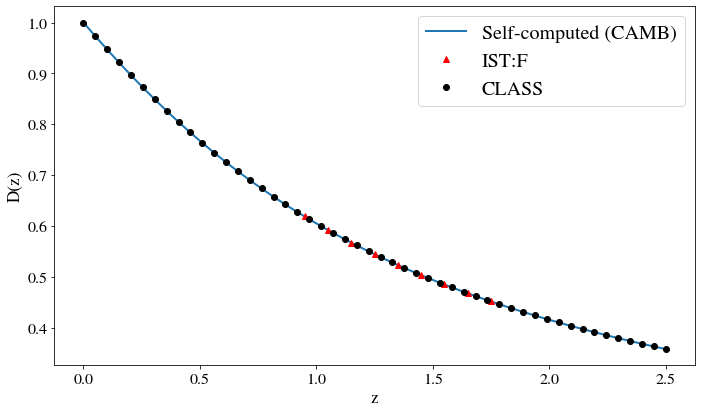

In [63]:
# Plot Growth factor, growth rate, sigma8
plt.figure(figsize=(10,6))
plt.plot(z_win, D, label="Self-computed (CAMB)")
plt.plot(data_ist[:, 0], data_ist[:, 2], 'r^', label="IST:F" )
plt.xlabel("z")
plt.ylabel("D(z)")
for i, zs in enumerate(np.linspace(0, 2.5, 50)):
    plt.plot(zs, cosmo_class.scale_independent_growth_factor(zs), 'ko', label="CLASS" if i == 0 else "")
plt.legend(loc=1);
#plt.xlim(0, 4)

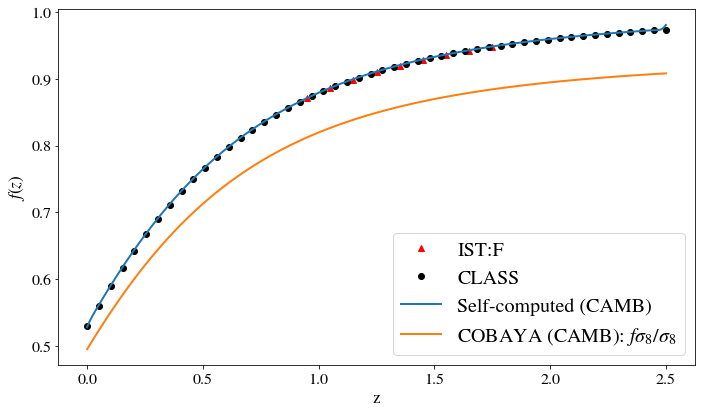

In [66]:
# Growth rate
plt.figure(figsize=(10,6))
plt.plot(data_ist[:, 0], data_ist[:, 1], 'r^', label="IST:F" )
for i, zs in enumerate(np.linspace(0, 2.5, 50)):
    plt.plot(zs, cosmo_class.scale_independent_growth_factor_f(zs), 'o',
             color='k', label="CLASS" if i == 0 else "")
plt.plot(np.linspace(0, 2.5, 500), f(np.linspace(0, 2.5, 500)), label="Self-computed (CAMB)")
plt.plot(z, theory_dic['fsigma8']/theory_dic['sigma_8'], label=r"COBAYA (CAMB): $f\sigma_8/\sigma_8$")
plt.xlabel("z")
plt.ylabel(r"$f(z)$")
plt.legend();

#### Testing the interpolators

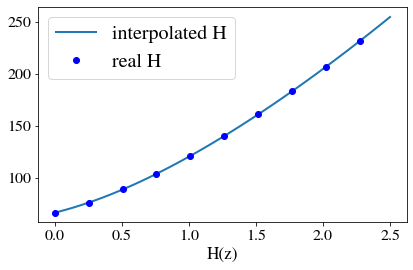

In [71]:
plt.plot(z_win, cosmology.cosmo_dic['H_z_func'](z_win),
         label='interpolated H')
plt.plot(z_win, cosmology.cosmo_dic['H'], 'bo', 
        markevery=10,
         label='real H')
plt.legend()
plt.xlabel("z")
plt.xlabel("H(z)");

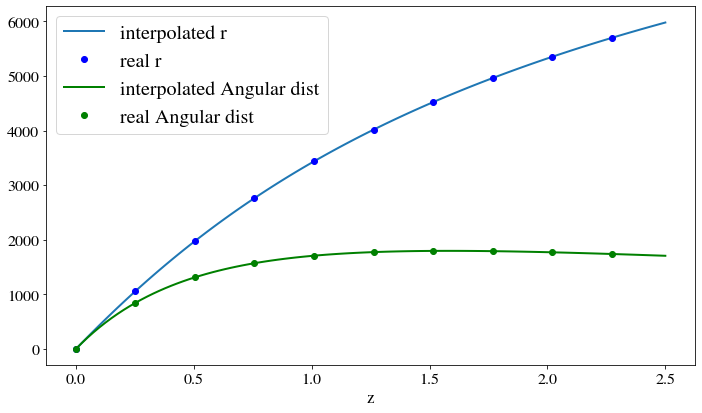

In [73]:
plt.figure(figsize=(10,6))
plt.plot(z_win, cosmology.cosmo_dic['r_z_func'](z_win), label='interpolated r')
plt.plot(z_win, cosmology.cosmo_dic['comov_dist'], 'bo', markevery=10, label='real r')
plt.plot(z_win, cosmology.cosmo_dic['d_z_func'](z_win), 'g-', label='interpolated Angular dist')
plt.plot(z_win, cosmology.cosmo_dic['angular_dist'], 'go', markevery=10, label='real Angular dist')
plt.legend()
plt.xlabel("Distances");
plt.xlabel("z");

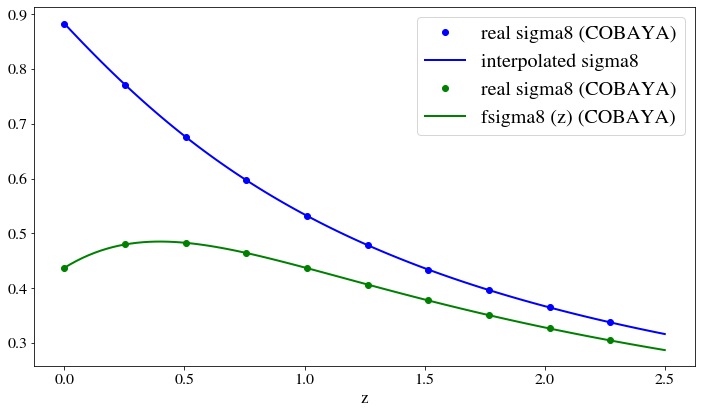

In [77]:
plt.figure(figsize=(10,6))
plt.plot(z_win, cosmology.cosmo_dic['sigma_8'], 'bo', markevery=10, label="real sigma8 (COBAYA)")
plt.plot(z_win, cosmology.cosmo_dic['sigma8_z_func'](z_win), 'b-', label='interpolated sigma8')
plt.plot(z_win, cosmology.cosmo_dic['fsigma8'], 'go', markevery=10, label="real sigma8 (COBAYA)")
plt.plot(z, theory_dic['fsigma8'], 'g-', label="fsigma8 (z) (COBAYA)")
plt.legend()
plt.xlabel("z");

### Step 5: Shear module and ```COBAYA```



In [78]:
from likelihood.photometric_survey.shear import Shear
from likelihood.general_specs.estimates import Galdist

In [79]:
galdist = Galdist(1)
n_z_normalized = galdist.n_i
n_z_normalized(3.85)

array(7.5090763e-23)

In [80]:
shear = Shear(cosmology.cosmo_dic)

In [81]:
shear.GC_window(0.2, 0.001, 1)

0.0026890270468942295

## Fiducial model

In [82]:
# Initialize cosmology class from likelihood.cosmo.cosmology
# By default: LCDM
fiducial_cosmology = Cosmology()
print(fiducial_cosmology.cosmo_dic)
print(fiducial_cosmology.cosmo_dic['ombh2'])

{'H0': 67.5, 'omch2': 0.122, 'ombh2': 0.022, 'mnu': 0.06, 'tau': 0.07, 'nnu': 3.046, 'ns': 0.9674, 'As': 2.1e-09, 'comov_dist': None, 'angular_dist': None, 'H': None, 'Pk_interpolator': None, 'Pk_delta': None, 'fsigma8': None, 'b_gal': 1.0, 'sigma_8': None, 'c': 299792.458, 'z_win': None, 'r_z_func': None, 'd_z_func': None, 'H_z_func': None, 'sigma8_z_func': None, 'fsigma8_z_func': None}
0.022


In [83]:
info_fiducial = {
    #Which parameters would you like to sample?
    'params': {
        # Fixed
        'ombh2': fiducial_cosmology.cosmo_dic['ombh2'], 
        'omch2': fiducial_cosmology.cosmo_dic['omch2'], 
        'H0': fiducial_cosmology.cosmo_dic['H0'], 
        'tau': fiducial_cosmology.cosmo_dic['tau'],
        'mnu': fiducial_cosmology.cosmo_dic['mnu'], 
        'nnu': fiducial_cosmology.cosmo_dic['nnu'],
        'ns': fiducial_cosmology.cosmo_dic['ns'],
        'As': fiducial_cosmology.cosmo_dic['As'],
        },
    #We should decide with Boltzmann we want for the fiducial: CAMB
    'theory': {'camb': {'stop_at_error': True, 'extra_args':{'num_massive_neutrinos': 1}}},
    #Where have you installed your modules (i.e: CAMB, polychord, likelihoods...)
    'packages_path': modules_path,
    #Likelihood: we load the likelihood as an external function
    'likelihood': {'one': None}
    }

In [94]:
model_fiducial = get_model(info_fiducial)

# Declare our desired theory product
# (there is no cosmological likelihood doing it for us)
model_fiducial.add_requirements({"Pk_interpolator": {"z": z_win,
                                    "k_max": k_max,
                                    "nonlinear": False,
                                    "vars_pairs": ([["delta_tot",
                                                     "delta_tot"]])},
                "comoving_radial_distance": {"z": z_win},
                "angular_diameter_distance": {"z": z_win},
                "Hubble": {"z": z_win, "units": "km/s/Mpc"},
                "fsigma8": {"z": z_win, "units": None}})

# Compute and extract the CMB power spectrum
# (In muK^-2, without l(l+1)/(2pi) factor)
# notice the empty dictionary below: all parameters are fixed
model_fiducial.logposterior({})


[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB


LogPosterior(logpost=0.0, logpriors=[0.0], loglikes=array([0.]), derived=[])

In [99]:
fiducial_cosmology.cosmo_dic['z_win']=z_win
fiducial_cosmology.cosmo_dic['comov_dist']= model_fiducial.provider.get_comoving_radial_distance(z_win),
fiducial_cosmology.cosmo_dic['angular_dist']= model_fiducial.provider.get_angular_diameter_distance(z_win),
fiducial_cosmology.cosmo_dic['H'] = model_fiducial.provider.get_Hubble(z_win),
fiducial_cosmology.cosmo_dic['Pk_interpolator'] = model_fiducial.provider.get_Pk_interpolator(nonlinear=False),
fiducial_cosmology.cosmo_dic['Pk_delta']= model_fiducial.provider.get_Pk_interpolator(("delta_tot", "delta_tot"), nonlinear=False)
fiducial_cosmology.cosmo_dic['fsigma8'] = model_fiducial.provider.get_fsigma8(z_win)

In [101]:
fiducial_cosmology.interp_H()
fiducial_cosmology.interp_comoving_dist()
fiducial_cosmology.interp_angular_dist()
#print(fiducial_cosmology.cosmo_dic)

In [102]:
fiducial_cosmology.cosmo_dic['d_z_func'](0.0000001)

array(0.00044411)

In [103]:
fiducial_cosmology.cosmo_dic['H']

(array([ 67.5       ,  68.32757882,  69.18629232,  70.07599414,
         70.99650458,  71.9476134 ,  72.9290827 ,  73.9406496 ,
         74.982029  ,  76.05291615,  77.15298915,  78.28191134,
         79.43933353,  80.62489613,  81.83823115,  83.078964  ,
         84.34671521,  85.64110201,  86.9617397 ,  88.30824298,
         89.68022712,  91.07730898,  92.49910793,  93.94524672,
         95.41535215,  96.90905572,  98.42599417,  99.96580993,
        101.52815151, 103.11267384, 104.71903848, 106.34691389,
        107.99597553, 109.66590599, 111.35639507, 113.06713981,
        114.79784449, 116.54822063, 118.3179869 , 120.10686909,
        121.91460005, 123.74091952, 125.58557409, 127.44831704,
        129.32890821, 131.22711388, 133.14270661, 135.07546513,
        137.02517412, 138.99162413, 140.97461139, 142.97393764,
        144.98941002, 147.0208409 , 149.0680477 , 151.13085279,
        153.20908331, 155.30257103, 157.41115221, 159.53466746,
        161.67296162, 163.82588361, 165.

### Step 6: Spec module and ```COBAYA```

In [104]:
from likelihood.spectroscopic_survey.spec import Spec

In [105]:
spec = Spec(cosmology.cosmo_dic, fiducial_cosmology.cosmo_dic)

In [107]:
spec.multipole_spectra(1.0, 0.05, 0)

21004.068570433075

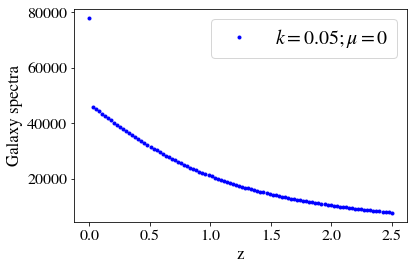

In [120]:
for i, z in enumerate(z_win):
    plt.plot(z, spec.multipole_spectra(z, 0.05, 0), 'b.',
            label=r"$k=0.05; \mu=0$" if i == 0 else "")
plt.xlabel("z");
plt.ylabel("Galaxy spectra");
plt.legend();